In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2019, 2025)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

# Player Stats
#player_stats = nfl.import_seasonal_data(years=yrs, s_type='ALL')

# Weekly Rosters
#weekly_rosters = nfl.import_weekly_rosters(years=yrs)

# Schedules
#schedules = nfl.import_schedules(years=yrs)

# Injuries
#injuries = nfl.import_injuries(years=yrs)

# Draft Data
#draft_data = nfl.import_draft_picks(years=yrs)

# Combine Data
#combine_data = nfl.import_combine_data(years=yrs)

# Weekly Fantasy Data
#weekly_fantasy_data = nfl.import_weekly_data(years=yrs)

# Officiating Data
#officiating_data = nfl.import_officials(years=yrs)

# Betting Lines
#betting_lines = nfl.import_sc_lines(yrs)

# Depth Charts
depth_charts = nfl.import_depth_charts(years=yrs)

# Next Gen Stats
#next_gen_stats = nfl.import_ngs_data(years=yrs, stat_type='passing')

2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


Attempt to make a dvoa-type metric. Explore how downs impact expected points to make a better epa. 
- Points Above Replacement [PAR]
- First Down Above Replacement [FDAR] how likely are you to obtain another first down on this drive?

Use strength of schedule and matchups to weight player performance. Include situations like 4th quarter.

Can I predict snap count of players? If so, does that help predict points or yards?

Make multiple functions that take in past data (play-by-play) 
- summarize the data by predicting the play outcome (yardage gained, score, 1st down)

Make a function that is able to summarize the effect of each variable on the outcome of the play

So, if each play occurs after the prior; I can make a cumulative sum that tracks the performance of teams
- New features like: Of last 100 plays how many have been touchdowns? How many have been sacks?
- total plays played

Can I feed all columns into a model to predict the future?
- Should I predict the next play? The game result? The next game result? Season win total?
- Can I find the most important features to then summarize for other problems? Can I then reduce the dimensions?
- Or should I just use averages and tendencies to summarize the current data in relation to future data?

Right now there is too much data for each player to put into one dataset to predict the next play. Goal: features for each player on the field (past yards, height, age...), but that would amount to about 200 columns and millions of rows. So, there must be feature reduction so that each player only has three or four columns to their name resulting in about 80 columns and millions of rows.
- Feature engineering to organize players based on three or four categories (athletisism, schemes, accolades...)
    - Production (reference for a category to qualify as being good)
        - explosive play rate
        - clutch rating
        - performance after explosive plays
        - consistency rating
        - teammate assistance
        - luck rating (drops, fumble recovery, missed field goals)
    - Tangibles (Athleticism)
        - age, age trends for position
        - height
        - weight
        - speed
        - strength
        - change in weight
        - injuries, return to injury effectiveness
        - total tackles endured
        - performance drop off on short rest times (thursday night games)
    - Schemes (Usage)
        - percent of snaps throwing, catching, running the ball (of specific player and of team)
        - 2-minute drill snap percentage
        - percent of snaps at each position
        - personnel frequencies
        - down/redzone usage
        - aggressiveness rating
        - contact rate (tackle rate)
    - Accolades (Intangibles)
        - salary
        - awards
        - draft stock
        - playoff wins
        - betting lines
        - how many teams have they been on?
- Reduce dimension through cluster analysis (referencing production differences)
- Combine all categories for each player on each play to predict the future

Similar approach could be to pivot the teammate/matchup/situation stats into long format for each player. The columns would be personal to each player, and the rows would have duplicated on the play dimension, meaning that each play would have 22 rows instead of one row for each play.

Develop Value Over Environment (VOE). Incorporate all situational stats (game time, personnel, home/away, teammate performance, teammate situational performance) to predict the outcome of the play. The difference between cumulative expectation and cumulative outcome for each individual player is assumed to be the fault of the individual player.

In [207]:
game_info = [
    'play_id', 'game_id', 'old_game_id_x', 'home_team', 'away_team', 'season_type', 'week', 
    'game_date', 'total_home_score', 'total_away_score', 'posteam', 'posteam_type', 'defteam', 
    'location', 'stadium', 'weather', 'temp', 'wind', 'roof', 'surface', 'home_coach', 'away_coach', 
    'stadium_id', 'game_stadium', 'away_score', 'home_score', 'result', 'total', 'spread_line', 
    'total_line', 'div_game', 'home_opening_kickoff', 'nflverse_game_id', 'old_game_id_y'
]

drive_info = [
    'drive', 'drive_real_start_time', 'drive_play_count', 'drive_time_of_possession', 
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score', 'drive_quarter_start', 
    'drive_quarter_end', 'drive_yards_penalized', 'drive_start_transition', 'drive_end_transition', 
    'drive_game_clock_start', 'drive_game_clock_end', 'drive_start_yard_line', 'drive_end_yard_line', 
    'drive_play_id_started', 'drive_play_id_ended', 'fixed_drive', 'fixed_drive_result'
]

play_info = [
    'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 
    'quarter_end', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 
    'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 
    'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 
    'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 
    'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
    'score_differential', 'posteam_score', 'defteam_score', 'posteam_score_post', 'defteam_score_post', 
    'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 
    'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 
    'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 
    'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 
    'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 
    'vegas_wpa', 'vegas_home_wpa', 'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp', 
    'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 
    'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 
    'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa'
]

player_actions = [
    'rush_attempt', 'pass_attempt', 'sack', 'qb_hit', 'qb_hit_1_player_id', 'qb_hit_1_player_name', 
    'qb_hit_2_player_id', 'qb_hit_2_player_name', 'solo_tackle', 'assist_tackle', 'tackled_for_loss', 
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name', 'tackle_for_loss_2_player_id', 
    'tackle_for_loss_2_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_1_player_id', 
    'forced_fumble_player_1_player_name', 'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id', 
    'forced_fumble_player_2_player_name', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 
    'fumble_lost', 'fumble_recovery_1_team', 'fumble_recovery_1_yards', 'fumble_recovery_1_player_id', 
    'fumble_recovery_1_player_name', 'fumble_recovery_2_team', 'fumble_recovery_2_yards', 
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name', 'interception', 'interception_player_id', 
    'interception_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 
    'pass_defense_1_player_id', 'pass_defense_1_player_name', 'pass_defense_2_player_id', 
    'pass_defense_2_player_name', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name', 
    'blocked_player_id', 'blocked_player_name', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'passer_player_id', 'passer_player_name', 'passing_yards', 
    'receiver_player_id', 'receiver_player_name', 'receiving_yards', 'rusher_player_id', 'rusher_player_name', 
    'rushing_yards', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_receiving_yards', 
    'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_rushing_yards', 'lateral_sack_player_id', 
    'lateral_sack_player_name', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 
    'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 
    'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 
    'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 
    'assist_tackle_4_team', 'solo_tackle_1_team', 'solo_tackle_2_team', 'solo_tackle_1_player_id', 
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name', 'solo_tackle_2_player_name', 'fumbled_1_team', 
    'fumbled_1_player_id', 'fumbled_1_player_name', 'fumbled_2_player_id', 'fumbled_2_player_name', 
    'fumbled_2_team', 'return_team', 'return_yards', 'penalty_team', 'penalty_player_id', 
    'penalty_player_name', 'penalty_yards', 'penalty', 'penalty_type', 'replay_or_challenge', 
    'replay_or_challenge_result', 'defensive_two_point_attempt', 'defensive_two_point_conv', 
    'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'first_down_rush', 'first_down_pass', 
    'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'touchback', 'safety', 'tackled_for_loss', 'fumble', 
    'complete_pass', 'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 
    'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 
    'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt'
]

special_teams = [
    'special_teams_play', 'st_play_type', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'blocked_player_id', 'blocked_player_name'
]

clock_and_time = [
    'start_time', 'time_of_day', 'play_clock', 'end_clock_time', 'drive_game_clock_start', 
    'drive_game_clock_end'
]

advanced_metrics = [
    'cp', 'cpoe', 'series', 'series_success', 'series_result', 'order_sequence', 'nfl_api_id', 
    'play_deleted', 'play_type_nfl', 'aborted_play', 'success', 'passer', 'passer_jersey_number', 
    'rusher', 'rusher_jersey_number', 'receiver', 'receiver_jersey_number', 'pass', 'rush', 'first_down', 
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id', 'name', 'jersey_number', 'id', 
    'fantasy_player_name', 'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds', 'qb_epa', 
    'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass', 
    'pass_oe', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 
    'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 
    'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 
    'defense_man_zone_type', 'defense_coverage_type'
]

## Transform to wide format

In [247]:
# Regulate pbp_data
pbp_data_copy = pbp_data[['game_id', 'week', 'posteam', 'defteam', 'play_id', 'play_type', 'offense_players', 'defense_players', 'yards_gained', 
                                        'ydstogo', 'down', 'wp', 'half_seconds_remaining', 'wpa', 'epa']].copy()

pbp_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293476 entries, 0 to 293475
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   game_id                 293476 non-null  object 
 1   week                    293476 non-null  int32  
 2   posteam                 277696 non-null  object 
 3   defteam                 277696 non-null  object 
 4   play_id                 293476 non-null  float32
 5   play_type               284881 non-null  object 
 6   offense_players         237531 non-null  object 
 7   defense_players         237531 non-null  object 
 8   yards_gained            284602 non-null  float32
 9   ydstogo                 293476 non-null  float32
 10  down                    246641 non-null  float32
 11  wp                      291793 non-null  float32
 12  half_seconds_remaining  293412 non-null  float32
 13  wpa                     289162 non-null  float32
 14  epa                 

In [248]:
def pivot_wide(data, side='offense'):
    # Turn off warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Keep only 'run' & 'pass' plays
    data = data[data['play_type'].isin(['run', 'pass'])]

    # Sort pbp_data
    data = data.sort_values(['game_id', 'play_id'])
    
    # Split the players column into multiple columns for each player
    players = data[side + '_players'].str.split(';', expand=True)

    # Ensure there are always 11 columns by filling missing values with None
    players = players.reindex(columns=range(11), fill_value=None)

    # Rename the columns
    players.columns = [
        side + 'player_1', side + 'player_2', side + 'player_3', side + 'player_4', 
        side + 'player_5', side + 'player_6', side + 'player_7', side + 'player_8', 
        side + 'player_9', side + 'player_10', side + 'player_11'
    ]

    # Concatenate the original pbp_data with the new offense_players columns
    pbp_wide = pd.concat([data, players], axis=1)

    # Drop duplicates on game_id and play_id
    pbp_wide = pbp_wide.drop_duplicates(subset=['game_id', 'play_id'])

    return pbp_wide

pbp_wide = pivot_wide(pbp_data_copy, side='defense')
pbp_wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209592 entries, 2 to 293470
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   game_id                 209592 non-null  object 
 1   week                    209592 non-null  int32  
 2   posteam                 209592 non-null  object 
 3   defteam                 209592 non-null  object 
 4   play_id                 209592 non-null  float32
 5   play_type               209592 non-null  object 
 6   offense_players         169873 non-null  object 
 7   defense_players         169873 non-null  object 
 8   yards_gained            209592 non-null  float32
 9   ydstogo                 209592 non-null  float32
 10  down                    208779 non-null  float32
 11  wp                      209592 non-null  float32
 12  half_seconds_remaining  209592 non-null  float32
 13  wpa                     209592 non-null  float32
 14  epa                 

## Clean depth_charts

In [261]:
# Remove duplicates on season, club_code, week, gsis_id
depth_charts_copy = depth_charts.drop_duplicates(subset=['season', 'club_code', 'week', 'gsis_id'])

dup_group = ['season', 'club_code', 'week', 'depth_team', 'position']

# Count group orientation
group_sizes = depth_charts_copy.groupby(dup_group)['gsis_id'].transform('size')

# Assign orientation only for duplicates
orientation = depth_charts_copy.groupby(dup_group).cumcount()
depth_charts_copy['orientation'] = np.where(
    group_sizes > 1,
    orientation.map({0: 'L', 1: 'R'}),
    ''
)
depth_charts_copy['position_label'] = depth_charts_copy['orientation'] + depth_charts_copy['position'] + depth_charts_copy['depth_team'].astype(str)
depth_charts_copy = depth_charts_copy.drop(columns=['orientation'])
depth_charts_copy['position_label'] = depth_charts_copy['position_label'].astype(str)

depth_charts_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190541 entries, 0 to 37311
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   season          190541 non-null  int32  
 1   club_code       190541 non-null  object 
 2   week            189323 non-null  float64
 3   game_type       190541 non-null  object 
 4   depth_team      190541 non-null  object 
 5   last_name       190541 non-null  object 
 6   first_name      190541 non-null  object 
 7   football_name   190541 non-null  object 
 8   formation       190541 non-null  object 
 9   gsis_id         190541 non-null  object 
 10  jersey_number   190541 non-null  object 
 11  position        190541 non-null  object 
 12  elias_id        190527 non-null  object 
 13  depth_position  190541 non-null  object 
 14  full_name       190541 non-null  object 
 15  position_label  190541 non-null  object 
dtypes: float64(1), int32(1), object(14)
memory usage: 24.0+ M

In [284]:
# Value counts of position_label
position_counts = depth_charts_copy['position_label'].value_counts()
print(position_counts.head(20))

nan     9859
LS1     3697
QB1     3690
K1      3679
QB2     3642
P1      3631
LWR1    3571
RWR1    3571
LCB1    3512
RCB1    3512
TE2     3218
LCB2    3209
RCB2    3209
RT1     3191
LT1     3191
LWR2    3116
RWR2    3116
C1      3090
TE1     3055
RB2     2950
Name: position_label, dtype: int64


## Transform to long format

In [268]:
def pivot_long(pbp_wide, depth_charts, side='offense'):
    # Rename the columns
    players_columns = [
        side + 'player_1', side + 'player_2', side + 'player_3', side + 'player_4', 
        side + 'player_5', side + 'player_6', side + 'player_7', side + 'player_8', 
        side + 'player_9', side + 'player_10', side + 'player_11'
    ]

    # Define id_vars as everything except for the side + 'player' columns
    id_vars = pbp_wide.columns.difference(players_columns).tolist()

    # Transform pbp_wide to long format with offense_player columns as rows
    pbp_long = pd.melt(pbp_wide, id_vars=id_vars, 
                    value_vars=players_columns, var_name=side + '_player_number', value_name='player_id')

    # Create season column, first 4 digits of game_id
    pbp_long['season'] = pbp_long['game_id'].astype(str).str[:4].astype(int)
    pbp_long['week'] = pbp_long['week'].astype(int)

    # Remove duplicates on season, club_code, week, gsis_id
    depth_charts_copy = depth_charts.drop_duplicates(subset=['season', 'club_code', 'week', 'gsis_id'])

    dup_group = ['season', 'club_code', 'week', 'depth_team', 'position']

    # Count group orientation
    group_sizes = depth_charts_copy.groupby(dup_group)['gsis_id'].transform('size')

    # Assign orientation only for duplicates
    orientation = depth_charts_copy.groupby(dup_group).cumcount()
    depth_charts_copy['orientation'] = np.where(
        group_sizes > 1,
        orientation.map({0: 'L', 1: 'R'}),
        ''
    )
    depth_charts_copy['position_label'] = depth_charts_copy['orientation'] + depth_charts_copy['position'] + depth_charts_copy['depth_team'].astype(str)
    depth_charts_copy = depth_charts_copy.drop(columns=['orientation'])
    depth_charts_copy['position_label'] = depth_charts_copy['position_label'].astype(str)

    # Merge depth chart data to pbp_long
    if side == 'offense':
        team_side = 'posteam'
    else:
        team_side = 'defteam'
    pbp_long = pbp_long.merge(depth_charts_copy[['season', 'club_code', 'week', 'gsis_id', 
                                            'position_label', 'full_name']],
                                left_on=['season', team_side, 'week', 'player_id'],
                                right_on=['season', 'club_code', 'week', 'gsis_id'],
                                how='left')

    pbp_long = pbp_long.sort_values(['game_id', 'play_id'])

    # Drop unnecessary columns
    pbp_long = pbp_long.drop(columns=['club_code', 'gsis_id', 'defense_players', 'offense_players', side + '_player_number'])

    # Drop duplicates on gaime_id, play_id, and player_id
    pbp_long = pbp_long.drop_duplicates(subset=['game_id', 'play_id', 'player_id'])

    # Drop na values
    pbp_long = pbp_long.dropna(subset=['position_label'])

    return pbp_long

pbp_long = pivot_long(pbp_wide, depth_charts, side='defense')
pbp_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781417 entries, 0 to 2270461
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   defteam                 object 
 1   down                    float32
 2   epa                     float32
 3   game_id                 object 
 4   half_seconds_remaining  float32
 5   play_id                 float32
 6   play_type               object 
 7   posteam                 object 
 8   week                    int32  
 9   wp                      float32
 10  wpa                     float32
 11  yards_gained            float32
 12  ydstogo                 float32
 13  player_id               object 
 14  season                  int32  
 15  position_label          object 
 16  full_name               object 
dtypes: float32(8), int32(2), object(7)
memory usage: 176.7+ MB


In [280]:
depth_charts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222382 entries, 0 to 37311
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   season          222382 non-null  int32  
 1   club_code       222382 non-null  object 
 2   week            220971 non-null  float64
 3   game_type       222382 non-null  object 
 4   depth_team      222382 non-null  object 
 5   last_name       222382 non-null  object 
 6   first_name      222382 non-null  object 
 7   football_name   222382 non-null  object 
 8   formation       222382 non-null  object 
 9   gsis_id         222382 non-null  object 
 10  jersey_number   222382 non-null  object 
 11  position        222382 non-null  object 
 12  elias_id        222368 non-null  object 
 13  depth_position  222382 non-null  object 
 14  full_name       222382 non-null  object 
dtypes: float64(1), int32(1), object(13)
memory usage: 26.3+ MB


# Feature Engineering

## Future Average Player Yards

instead of looking at all the data at the same time, make multiple models for the most important aspects of each play (coverage type, offensive personnel, seconds remaining in half...) this way the models will automatically account for the different situations. the alternative is simple but risks losing info in the melting pot of combining all situational data into one signle model at the same time (deep learning might be able to account of the complexity).

add position label to pbp_long

create matrix that denotes each play on each play as their position and their depth position

is there data available to assign roles to players (left tackle, X reciever, blocking TE, zone CB, run stuffer DT...)?

In [274]:
def future_plyr_performance(pbp_data, side='offense', diagnostics=False, dependent_var='epa'):
    # Regulate pbp_data
    pbp_data_copy = pbp_data[['game_id', 'week', 'posteam', 'defteam', 'play_id', 'play_type', 'offense_players', 'defense_players', 'yards_gained', 
                                        'ydstogo', 'down', 'wp', 'half_seconds_remaining', 'wpa', 'epa']].copy()

    # Call pivot_wide function
    pbp_wide = pivot_wide(pbp_data_copy, side=side)

    # Call pivot_long function
    pbp_long = pivot_long(pbp_wide, depth_charts, side=side)
    
    print(f'size of dataframe in gigabytes initially: {pbp_long.memory_usage(deep=True).sum() / 1e9}')
    
    # Cache the grouped object
    grouped = pbp_long.groupby('player_id')

    # Define decimal places for rounding
    decimal_places = 1

    # Cumulative stats
    pbp_long['ones'] = 1
    pbp_long['cumltv_plyr_snaps'] = grouped['ones'].cumsum()
    pbp_long['cumltv_plyr_epa'] = grouped['epa'].cumsum()
    pbp_long['cumltv_plyr_wpa'] = grouped['wpa'].cumsum()
    pbp_long['cumltv_plyr_yards'] = grouped['yards_gained'].cumsum()
    pbp_long['cumltv_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).cumsum())
    pbp_long['cumltv_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).cumsum())
    pbp_long['cumltv_plyr_hard_yards'] = grouped['yards_gained'].transform(lambda x: (x - pbp_long.loc[x.index, 'ydstogo']).cumsum())
    pbp_long['cmltv_plyr_yards_per_snap'] = pbp_long['cumltv_plyr_yards'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cmltv_plyr_epa_per_snap'] = pbp_long['cumltv_plyr_epa'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cumltv_plyr_explosive_play_rate'] = pbp_long['cumltv_plyr_explosive_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cumltv_plyr_negative_play_rate'] = pbp_long['cumltv_plyr_negative_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cumltv_plyr_hard_yards_rate'] = pbp_long['cumltv_plyr_hard_yards'] / pbp_long['cumltv_plyr_snaps']
    pbp_long = pbp_long.round(decimals=decimal_places)

    print(f'size of dataframe in gigabytes after cmltv stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Rolling averages
    rolling_window = 100  # snaps for recency bias
    pbp_long['running_avg_plyr_snaps'] = grouped['ones'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).count())
    pbp_long.drop(columns='ones', inplace=True)
    pbp_long['running_avg_plyr_epa'] = grouped['epa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_hard_yards'] = pbp_long['running_avg_plyr_yards'] - pbp_long['running_avg_plyr_ydstogo']
    pbp_long['running_avg_plyr_yards_per_snap'] = pbp_long['running_avg_plyr_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_epa_per_snap'] = pbp_long['running_avg_plyr_epa'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_explosive_play_rate'] = pbp_long['running_avg_plyr_explosive_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_negative_play_rate'] = pbp_long['running_avg_plyr_negative_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_hard_yards_rate'] = pbp_long['running_avg_plyr_hard_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long = pbp_long.round(decimals=decimal_places)

    print(f'size of dataframe in gigabytes after running_avg_plyr stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Consistency stats
    pbp_long['consistency_plyr_epa'] = grouped['epa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long = pbp_long.round(decimals=decimal_places)

    print(f'size of dataframe in gigabytes after consistency_plyr stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Clutch stats
    pbp_long['clutch_play_indicator'] = np.where(
        ((pbp_long['half_seconds_remaining'] <= 120) & (pbp_long['wp'] >= 0.025)) | # seconds remaining in the half and reasonable win probability
        ((pbp_long['wp'] <= 0.33) & (pbp_long['wp'] >= 0.025)), # win probability threshold for clutch situations
        1, 0)
    pbp_long['clutch_plyr_epa'] = grouped['epa'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long = pbp_long.round(decimals=decimal_places)


    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler

    # Define X, y
    X = pbp_long.drop(columns=['game_id', 'week', 'play_id', 'posteam', 'defteam', 'position_label', 'player_id', 'play_type', 'full_name', 'season'])

    # Future performance
    # Calculate future yards gained by player
    pbp_long['future_plyr_yards'] = pbp_long.groupby('player_id', group_keys=False)['yards_gained'].apply(lambda x: x.shift(-1).rolling(5, min_periods=1).sum())

    # Calculate future epa gained by player
    pbp_long['future_plyr_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(-1).rolling(5, min_periods=1).sum())

    y = pbp_long['future_plyr_' + dependent_var]

    # Replace NaN values with 0
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    # Initialize the model
    model = Ridge(alpha=10.0)
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    # Iterate through KFold splits
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if diagnostics:
            print(f'Fold MSE: {mse}, R2: {r2}')

    # Apply model to the entire dataset
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict(X_scaled)
    pbp_long['expected_plyr_' + dependent_var] = y_pred
    pbp_long = pbp_long[['game_id', 'play_id', 'position_label', 'player_id', 
                         'future_plyr_' + dependent_var, 'expected_plyr_' + dependent_var]].copy()
    
    # Diagnostics
    if diagnostics:
        # Smallest, closest to zero, and largest coefficients
        smallest_coefficients = pd.Series(model.coef_).nsmallest(4)
        coef_names = X.columns[smallest_coefficients.index]
        smallest_coefficients.index = coef_names

        largest_coefficients = pd.Series(model.coef_).nlargest(4)
        coef_names = X.columns[largest_coefficients.index]
        largest_coefficients.index = coef_names

        # Closest to zero coefficients
        abs_coefs = pd.Series(model.coef_).abs()
        closest_to_zero_indices = abs_coefs.nsmallest(4).index
        closest_to_zero_coefficients = pd.Series(model.coef_)[closest_to_zero_indices]
        closest_to_zero_coefficients.index = X.columns[closest_to_zero_indices]

        # Combine all for display
        coefficients = pd.concat([
            smallest_coefficients.rename('Smallest'),
            closest_to_zero_coefficients.rename('Closest to Zero'),
            largest_coefficients.rename('Largest')
        ])
        print(f'Coefficients:\n{coefficients}')

        # Scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(pbp_long['expected_plyr_' + dependent_var], pbp_long['future_plyr_' + dependent_var], alpha=0.01, linewidths=1, edgecolors='black')
        plt.ylabel('True Values')
        plt.xlabel('Predictions')
        plt.title('True vs Predicted Values')
        plt.plot([y.quantile(0.025), y.quantile(0.975)], [y.quantile(0.025), y.quantile(0.975)], color='red', linestyle='--')
        plt.show()
    
    pbp_long['expected_plyr_' + dependent_var] = pbp_long['expected_plyr_' + dependent_var].round(decimals=2)

    # Pivot the DataFrame to get player stats in wide format
    pbp_long['expected_plyr_' + dependent_var] = pbp_long['expected_plyr_' + dependent_var].round(decimals=2)
    pbp_wide = pbp_long.pivot_table(index=['game_id', 'play_id'], 
                                     columns='position_label', 
                                     values=['expected_plyr_' + dependent_var],
                                     aggfunc='first').reset_index()
    
    # Flatten the MultiIndex columns
    pbp_wide.columns = ['_'.join(col).strip() for col in pbp_wide.columns.values]

    return pbp_wide

size of dataframe in gigabytes initially: 0.890271101
size of dataframe in gigabytes after cmltv stats: 1.101368213
size of dataframe in gigabytes after running_avg_plyr stats: 1.273524917
size of dataframe in gigabytes after consistency_plyr stats: 1.359603269
Fold MSE: 7.272317571674517, R2: 0.2669160032834046
Fold MSE: 7.283720249725151, R2: 0.2669181910482007
Coefficients:
down                               -0.378838
ydstogo                            -0.328751
cumltv_plyr_snaps                  -0.307194
clutch_plyr_yards                  -0.239513
consistency_plyr_wpa               -0.003470
cumltv_plyr_explosive_play_rate     0.004096
consistency_plyr_epa                0.004426
consistency_plyr_explosive_plays    0.005495
epa                                 1.450616
running_avg_plyr_epa                0.413250
clutch_plyr_ydstogo                 0.337759
wp                                  0.279781
dtype: float64


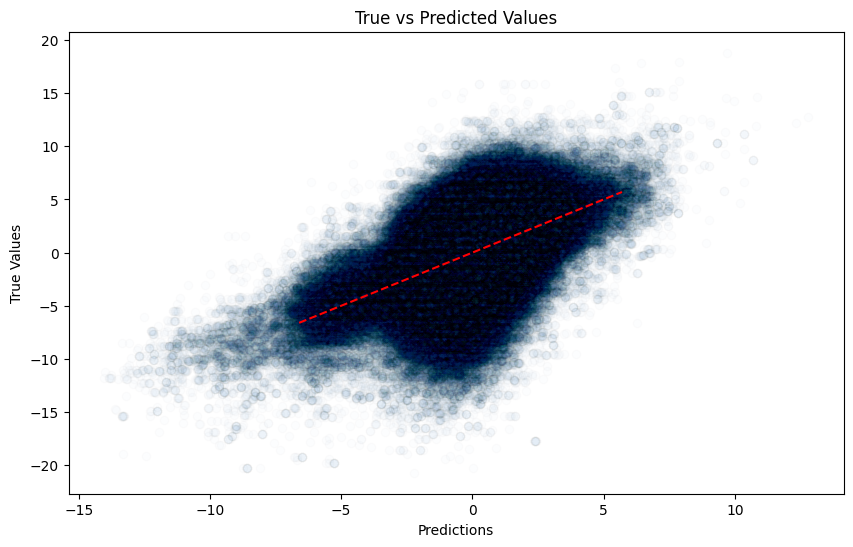

In [275]:
pbp_future_plyr_performance_offense = future_plyr_performance(pbp_data, side='offense', diagnostics=True, dependent_var='epa')

size of dataframe in gigabytes initially: 0.886396975
size of dataframe in gigabytes after cmltv stats: 1.096543527
size of dataframe in gigabytes after running_avg_plyr stats: 1.267559559
size of dataframe in gigabytes after consistency_plyr stats: 1.353067575
Fold MSE: 7.292863892909029, R2: 0.26384830435147144
Fold MSE: 7.282493491060615, R2: 0.2627452187933349
Coefficients:
down                              -0.384111
ydstogo                           -0.323258
clutch_plyr_explosive_plays       -0.196794
cumltv_plyr_yards                 -0.133306
cumltv_plyr_negative_play_rate     0.001402
consistency_plyr_wpa              -0.002095
cumltv_plyr_wpa                   -0.002567
cumltv_plyr_explosive_play_rate   -0.002907
epa                                1.456001
running_avg_plyr_epa               0.418307
wp                                 0.303397
cumltv_plyr_explosive_plays        0.280683
dtype: float64


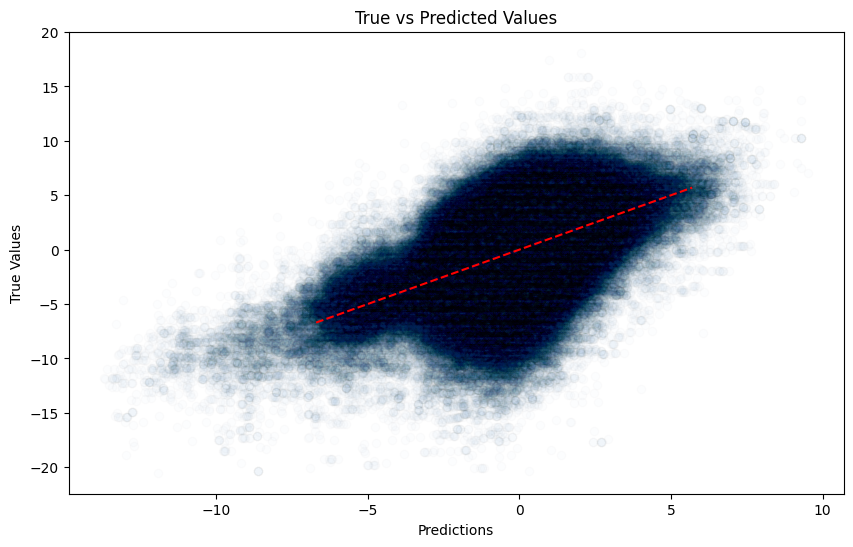

,game_id_,play_id_,expected_plyr_epa_C2,expected_plyr_epa_CB1,expected_plyr_epa_CB2,expected_plyr_epa_CB3,expected_plyr_epa_DB1,expected_plyr_epa_DB2,expected_plyr_epa_DB3,expected_plyr_epa_DE1,...,expected_plyr_epa_SS1,expected_plyr_epa_SS2,expected_plyr_epa_SS3,expected_plyr_epa_T3,expected_plyr_epa_TE1,expected_plyr_epa_TE2,expected_plyr_epa_TE3,expected_plyr_epa_WR2,expected_plyr_epa_WR3,expected_plyr_epa_nan
0,2019_01_ATL_MIN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.81
1,2019_01_ATL_MIN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70
2,2019_01_ATL_MIN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.20
3,2019_01_ATL_MIN,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019_01_ATL_MIN,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019_01_ATL_MIN,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.18
6,2019_01_ATL_MIN,298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.70
7,2019_01_ATL_MIN,342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.81
8,2019_01_ATL_MIN,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019_01_ATL_MIN,392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
# Run the basic stats function
pbp_future_plyr_performance_defense = future_plyr_performance(pbp_data, side='defense', diagnostics=True, dependent_var='epa')
pbp_future_plyr_performance_defense.head(10)

In [277]:
pbp_future_plyr_performance_offense.memory_usage(deep=True).sum() / 1e9

0.203935999

## VOE

In [219]:
def voe_model(pbp_data, diagnostics=False):
    # Turn off warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Call the function to get the future player performance
    #pbp_future_plyr_performance_offense = future_plyr_performance(pbp_data, offense=True, diagnostics=diagnostics, dependent_var='epa')
    #pbp_future_plyr_performance_defense = future_plyr_performance(pbp_data, offense=False, diagnostics=diagnostics, dependent_var='epa')

    # Define data
    pbp_data_copy = pbp_data[['play_type', 'offense_formation',  'defenders_in_box', 'ydstogo', 'half_seconds_remaining', 'wp', 
        'defense_personnel', 'offense_personnel', 'number_of_pass_rushers', 'route', 'defense_man_zone_type', 'defense_coverage_type', 
        'run_location', 'temp', 'wind', 'roof', 'surface', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
        'game_id', 'play_id', 'epa']].sort_values(['game_id', 'play_id']).copy()

    # Keep only 'run' & 'pass' plays
    pbp_data_copy = pbp_data_copy[pbp_data_copy['play_type'].isin(['run', 'pass'])]

    # Convert offense_personnel and defense_personnel to integer counts
    offense_personnel = pbp_data_copy['offense_personnel'].fillna('')
    pbp_data_copy['rb_count'] = offense_personnel.str.extract(r'(\d+)\s*RB').astype(float)
    pbp_data_copy['te_count'] = offense_personnel.str.extract(r'(\d+)\s*TE').astype(float)
    pbp_data_copy['wr_count'] = offense_personnel.str.extract(r'(\d+)\s*WR').astype(float)
    pbp_data_copy['fb_count'] = offense_personnel.str.extract(r'(\d+)\s*FB').astype(float)

    defense_personnel = pbp_data_copy['defense_personnel'].fillna('')
    pbp_data_copy['dl_count'] = defense_personnel.str.extract(r'(\d+)\s*DL').astype(float)
    pbp_data_copy['lb_count'] = defense_personnel.str.extract(r'(\d+)\s*LB').astype(float)
    pbp_data_copy['db_count'] = defense_personnel.str.extract(r'(\d+)\s*DB').astype(float)

    pbp_data_copy.drop(columns=['offense_personnel', 'defense_personnel'], inplace=True)

    # Convert categorical variables to dummy variables
    categorical_cols = ['play_type', 'offense_formation', 'route', 
                'defense_man_zone_type', 'defense_coverage_type', 'run_location', 'temp', 'wind', 'roof', 'surface']
    pbp_data_copy = pd.get_dummies(pbp_data_copy, columns=categorical_cols, drop_first=True)
    pbp_data_copy.fillna(0, inplace=True)

    # Merge with future player performance data
    pbp_data_copy = pbp_data_copy.merge(pbp_future_plyr_performance_offense, on=['game_id', 'play_id'], how='left')
    pbp_data_copy = pbp_data_copy.merge(pbp_future_plyr_performance_defense, on=['game_id', 'play_id'], how='left')

    # Define X, y
    X = pbp_data_copy.drop(columns=['game_id', 'play_id', 'epa'])
    y = pbp_data_copy['epa']

    # Replace NaN values with 0
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    # Initialize the mlp model
    from sklearn.neural_network import MLPRegressor
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor

    # Initialize the model
    #model = MLPRegressor(hidden_layer_sizes=(150, 200, 25, 5), # architecture of the neurons in each layer
    #                     max_iter=10000, # maximum iterations of the model 
     #                    tol=0.000001, # tolerance for convergence
     #                    alpha=100 # L2 regularization parameter
     #                    random_state=42)
    model = XGBRegressor(n_estimators=1000, 
                         learning_rate=0.025, # rate that the model is allowing the weights to change
                         max_depth=15, # maximum depth of the tree
                            gamma=0.15, # minimum loss reduction required to make a further partition of a leaf node
                            subsample=0.8,
                            colsample_bytree=0.9,
                            reg_alpha=0.25, # L1 regularization term on weights, shrinks weights to zero
                            reg_lambda=0.75, # L2 regularization term on weights
                         random_state=42)
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    # Iterate through KFold splits

    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if diagnostics:
            print(f'Fold MSE: {mse}, R2: {r2}')

    # Apply model to the entire dataset
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict(X_scaled)
    pbp_data_copy['expected_epa'] = y_pred

    # Diagnostics
    if diagnostics:
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(pbp_data_copy['expected_epa'], pbp_data_copy['epa'], alpha=0.01, linewidths=1, edgecolors='black')
        plt.ylabel('Observed epa')
        plt.xlabel('Predicted epa')
        plt.title('True vs Predicted Values')
        plt.plot([y.quantile(0.025), y.quantile(0.975)], [y.quantile(0.025), y.quantile(0.975)], color='red', linestyle='--')
        plt.grid()
        plt.show()

    # Calculate the difference between observed and expected epa
    pbp_data_copy['epa_over_expected'] = pbp_data_copy['epa'] - pbp_data_copy['expected_epa']
    pbp_data_copy = pbp_data_copy[['game_id', 'play_id', 'epa_over_expected', 'expected_epa']].copy()
    
    return pbp_data_copy

# Run the VOE model
pbp_voe = voe_model(pbp_data, diagnostics=True)

KeyboardInterrupt: 

In [ ]:
pbp_voe.head()

,game_id,play_id,epa_over_expected,expected_epa
0,2019_01_ATL_MIN,51.0,-0.004105,-1.654658
1,2019_01_ATL_MIN,79.0,-0.285045,-0.253869
2,2019_01_ATL_MIN,100.0,1.348677,-1.206538
3,2019_01_ATL_MIN,185.0,1.009694,-0.751564
4,2019_01_ATL_MIN,214.0,0.190279,2.595097


In [ ]:
# Regulate pbp_data
pbp_data_copy = pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type', 'offense_players', 'defense_players', 'yards_gained', 
                                    'ydstogo', 'down', 'wp', 'half_seconds_remaining', 'wpa', 'epa']].copy()

# Call pivot_wide function
pbp_wide_offense = pivot_wide(pbp_data_copy, side='offense')
pbp_wide_defense = pivot_wide(pbp_data_copy, side='defense')

# Call pivot_long function
pbp_long_offense = pivot_long(pbp_wide_offense, depth_charts, side='offense')
pbp_long_defense = pivot_long(pbp_wide_defense, depth_charts, side='defense')

# Concatenate the two DataFrames
pbp_long = pd.concat([pbp_long_offense, pbp_long_defense], ignore_index=True)

# Merge with pbp_voe to get epa_over_expected
pbp_long = pbp_long.merge(pbp_voe, on=['game_id', 'play_id'], how='left')

# Drop duplicates over play_id and player_id
pbp_long = pbp_long.drop_duplicates(subset=['game_id', 'play_id', 'player_id'])

pbp_long.head()

,down,epa,game_id,half_seconds_remaining,play_id,play_type,posteam,week,wp,wpa,yards_gained,ydstogo,offense_player_number,player_id,season,full_name,defense_player_number,epa_over_expected,expected_epa
0,1.0,-1.658763,2019_01_ATL_MIN,1800.0,51.0,pass,ATL,1,0.433208,-0.035015,-8.0,10.0,offenseplayer_1,00-0035235,2019,Kaleb McGary,NaN,-0.004105,-1.654658
1,1.0,-1.658763,2019_01_ATL_MIN,1800.0,51.0,pass,ATL,1,0.433208,-0.035015,-8.0,10.0,offenseplayer_2,00-0028042,2019,Luke Stocker,NaN,-0.004105,-1.654658
2,1.0,-1.658763,2019_01_ATL_MIN,1800.0,51.0,pass,ATL,1,0.433208,-0.035015,-8.0,10.0,offenseplayer_3,00-0031279,2019,Jake Matthews,NaN,-0.004105,-1.654658
3,1.0,-1.658763,2019_01_ATL_MIN,1800.0,51.0,pass,ATL,1,0.433208,-0.035015,-8.0,10.0,offenseplayer_4,00-0026997,2019,Alex Mack,NaN,-0.004105,-1.654658
4,1.0,-1.658763,2019_01_ATL_MIN,1800.0,51.0,pass,ATL,1,0.433208,-0.035015,-8.0,10.0,offenseplayer_5,00-0034837,2019,Calvin Ridley,NaN,-0.004105,-1.654658


In [ ]:
# Create cumulative count of rows by player_id
pbp_long['ones'] = 1
pbp_long['cumltv_plyr_snaps'] = pbp_long.groupby('player_id')['ones'].cumsum()

# Filter for only 250+ snaps
pbp_long = pbp_long[pbp_long['cumltv_plyr_snaps'] >= 250]

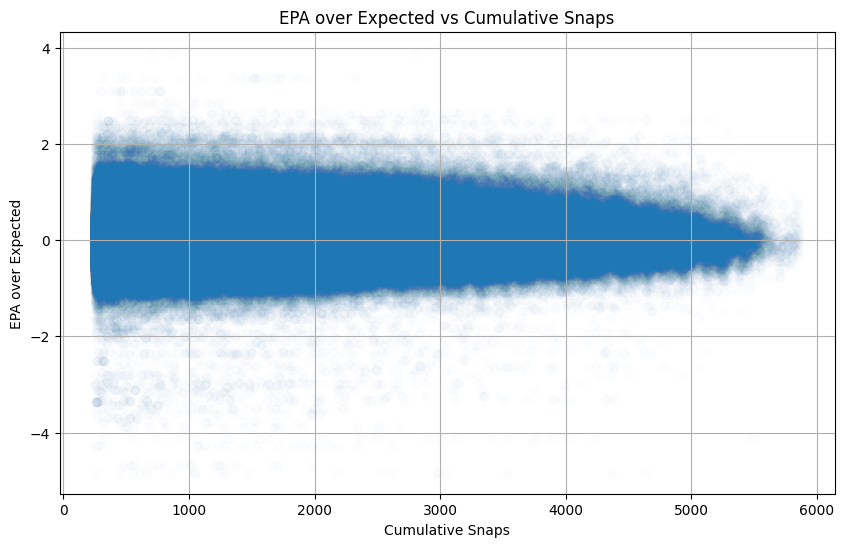

In [ ]:
# Plot voe against cmltv_snaps
plt.figure(figsize=(10, 6))
plt.scatter(pbp_long['cumltv_plyr_snaps'], pbp_long['epa_over_expected'], alpha=0.01, linewidths=1)
plt.ylabel('EPA over Expected')
plt.xlabel('Cumulative Snaps')
plt.title('EPA over Expected vs Cumulative Snaps')
plt.grid()
plt.show()

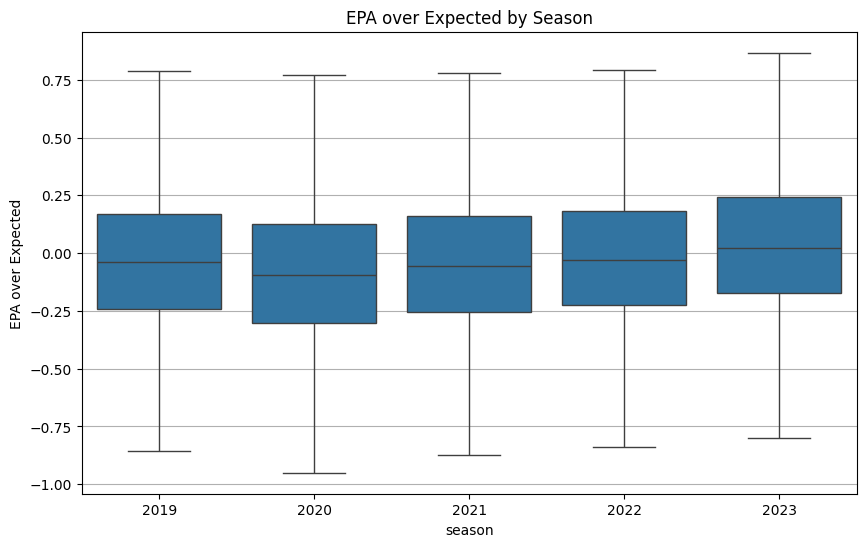

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='epa_over_expected', data=pbp_long, showfliers=False)
plt.ylabel('EPA over Expected')
plt.title('EPA over Expected by Season')
plt.grid(axis='y')
plt.show()

In [ ]:
# Calculate the cumulative epa_over_expected for each player
pbp_long = pbp_long.sort_values(['season', 'play_id'])
pbp_long['VOE'] = pbp_long.groupby(['player_id', 'season'])['epa_over_expected'].cumsum()

pbp_long.head()

,down,epa,game_id,half_seconds_remaining,play_id,play_type,posteam,week,wp,wpa,...,offense_player_number,player_id,season,full_name,defense_player_number,epa_over_expected,expected_epa,ones,cumltv_plyr_snaps,VOE
327155,1.0,0.622102,2019_16_NYG_WAS,1800.0,36.0,pass,NYG,16,0.433208,0.007708,...,offenseplayer_1,00-0034346,2019,Will Hernandez,NaN,-0.426785,1.048887,1,871.0,-0.426785
327156,1.0,0.622102,2019_16_NYG_WAS,1800.0,36.0,pass,NYG,16,0.433208,0.007708,...,offenseplayer_2,00-0027955,2019,Nate Solder,NaN,-0.426785,1.048887,1,817.0,-0.426785
327157,1.0,0.622102,2019_16_NYG_WAS,1800.0,36.0,pass,NYG,16,0.433208,0.007708,...,offenseplayer_3,00-0027891,2019,Golden Tate,NaN,-0.426785,1.048887,1,470.0,-0.426785
327158,1.0,0.622102,2019_16_NYG_WAS,1800.0,36.0,pass,NYG,16,0.433208,0.007708,...,offenseplayer_4,00-0034844,2019,Saquon Barkley,NaN,-0.426785,1.048887,1,574.0,-0.426785
327159,1.0,0.622102,2019_16_NYG_WAS,1800.0,36.0,pass,NYG,16,0.433208,0.007708,...,offenseplayer_5,00-0029164,2019,Mike Remmers,NaN,-0.426785,1.048887,1,805.0,-0.426785


In [ ]:
# groupby player_id and season to find max voe
pbp_long['avg_voe'] = pbp_long.groupby(['full_name', 'season'])['VOE'].transform(lambda x: x.fillna(0).mean())

# remove duplicates
pbp_long = pbp_long.drop_duplicates(subset=['full_name', 'season'])
pbp_long = pbp_long[['full_name', 'season', 'avg_voe']].copy()

# Sort by max_voe
pbp_long = pbp_long.sort_values(['season', 'avg_voe'], ascending=[True, False])

pbp_long.head(10) # All players come from 2018 for some reason, must be a bias in the future player performance function

,full_name,season,avg_voe
165960,James Daniels,2019,39.072392
165964,Cody Whitehair,2019,39.072392
165966,Charles Leno,2019,39.039688
165963,Allen Robinson,2019,38.835438
289518,Mitchell Trubisky,2019,31.791716
174098,Matt Feiler,2019,31.287228
174101,Alejandro Villanueva,2019,31.287228
174103,David DeCastro,2019,31.287228
257470,Michael Deiter,2019,29.879629
182445,Kyle Allen,2019,29.544893


In [ ]:
# Highest voe in 2019
pbp_long[pbp_long['season'] == 2019].tail(10)

,full_name,season,avg_voe
367173,Travis Kelce,2019,-59.139122
363122,Ryan Tannehill,2019,-60.777164
363121,A.J. Brown,2019,-61.493797
97619,Laurent Duvernay-Tardif,2019,-61.939911
367176,Patrick Mahomes,2019,-66.707855
363116,Taylor Lewan,2019,-68.963509
363118,Nate Davis,2019,-69.657631
97615,Mitchell Schwartz,2019,-71.451958
97614,Austin Reiter,2019,-71.820274
2235185,NaN,2019,NaN


In [ ]:
# Highest voe in 2020
pbp_long[pbp_long['season'] == 2020].tail(10)

,full_name,season,avg_voe
602262,Mike Remmers,2020,-121.758484
374453,Aaron Rodgers,2020,-123.653862
374447,Elgton Jenkins,2020,-125.042946
602257,Austin Reiter,2020,-125.576164
602255,Travis Kelce,2020,-138.334091
602261,Tyreek Hill,2020,-140.094376
602259,Eric Fisher,2020,-148.931412
602264,Andrew Wylie,2020,-151.069962
602258,Patrick Mahomes,2020,-152.184845
2277993,NaN,2020,NaN
